***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from io import BytesIO
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [2]:
image_dir = Path('./Imagenes/Trayectorias_comprimidas/longitud_8/raw-img-v5')

file_paths = list(image_dir.rglob("*.jpg")) + \
             list(image_dir.rglob("*.jpeg")) + \
             list(image_dir.rglob("*.png"))

complete_df = pd.DataFrame()
complete_df['file_name'] = [str(p) for p in file_paths]
complete_df['class_name'] = complete_df['file_name'].map(lambda x: Path(x).parent.name)

### COMPROBACIÓN ###
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)


Número total de imágenes: 13668
class_name
AIS(37)       4160
AIS(31-32)    3260
AIS(70-79)    1216
AIS(90-99)    1058
AIS(36)       1014
AIS(60-69)     993
AIS(30)        896
AIS(80-89)     570
AIS(52)        310
AIS(56-57)     191
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(10))
print()
print("Ejm. conjunto test:")
print(test_df.head(10))

Nº de imágenes en train: 10937
class_name
AIS(37)       3328
AIS(31-32)    2608
AIS(70-79)     973
AIS(90-99)     847
AIS(36)        812
AIS(60-69)     795
AIS(30)        717
AIS(80-89)     456
AIS(52)        248
AIS(56-57)     153
Name: count, dtype: int64

Nº de imágenes en test: 2731
class_name
AIS(37)       832
AIS(31-32)    652
AIS(70-79)    243
AIS(90-99)    211
AIS(36)       202
AIS(60-69)    198
AIS(30)       179
AIS(80-89)    114
AIS(52)        62
AIS(56-57)     38
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name  class_name
0  Imagenes\Trayectorias_comprimidas\longitud_8\r...     AIS(37)
1  Imagenes\Trayectorias_comprimidas\longitud_8\r...  AIS(31-32)
2  Imagenes\Trayectorias_comprimidas\longitud_8\r...  AIS(60-69)
3  Imagenes\Trayectorias_comprimidas\longitud_8\r...     AIS(36)
4  Imagenes\Trayectorias_comprimidas\longitud_8\r...     AIS(37)
5  Imagenes\Trayectorias_comprimidas\longitud_8\r...  AIS(56-57)
6  Imagenes\Trayec

***Imágenes de entrenamiento y test antes del pre-procesado :***

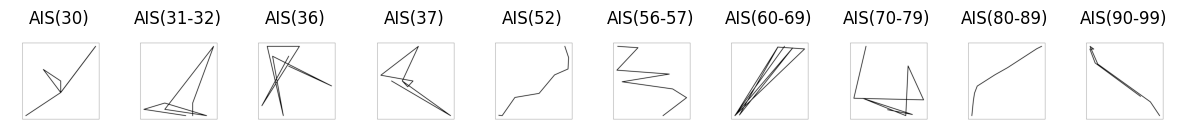

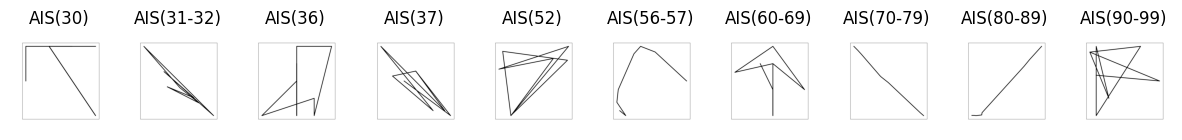

In [4]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    grouped = df.groupby('class_name')
    
    for i, (class_name, group) in enumerate(grouped):
        image_path = group['file_name'].iloc[0]
        image = Image.open(image_path).convert("RGB")
        
        plt.subplot(1, len(grouped), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} disponible")

transform = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.ToTensor()])

def preprocesado_imagen(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

for index, row in train_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_train.append(image_tensor)
    y_train.append(row['class_name'])

for index, row in test_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_test.append(image_tensor)
    y_test.append(row['class_name'])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

### COMPROBACIÓN ###
print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)


cuda disponible
X_train: torch.Size([10937, 3, 227, 227]) cpu
y_train: torch.Size([10937]) cpu
X_test: torch.Size([2731, 3, 227, 227]) cpu
y_test: torch.Size([2731]) cpu


# ***AlexNet :***

In [ ]:
def get_alexnet_model(num_classes, pretrained):
    if pretrained:
        modelo = alexnet(weights=AlexNet_Weights.DEFAULT)
    else:
        modelo = alexnet(weights=None)

    modelo.classifier[6] = nn.Linear(modelo.classifier[6].in_features, num_classes)

    if pretrained:
        for param in modelo.features.parameters():
            param.requires_grad = False
            
        for param in modelo.classifier[6].parameters():
            param.requires_grad = True

    return modelo

# ***ResNet50 :***

In [6]:
def get_resnet50_model(num_classes, pretrained):
    if pretrained:
        modelo = resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        modelo = resnet50(weights=None)

    modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.fc.parameters():
            param.requires_grad = True

    return modelo

# ***DenseNet121 :***

In [6]:
def get_densenet121_model(num_classes, pretrained):
    if pretrained:
        modelo = densenet121(weights=DenseNet121_Weights.DEFAULT)
    else:
        modelo = densenet121(weights=None)

    modelo.classifier = nn.Linear(modelo.classifier.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier.parameters():
            param.requires_grad = True

    return modelo

# ***ConvNeXt Tiny :***

In [6]:
def get_convnext_tiny_model(num_classes, pretrained):
    if pretrained:
        modelo = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
    else:
        modelo = convnext_tiny(weights=None)

    modelo.classifier[2] = nn.Linear(modelo.classifier[2].in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier[2].parameters():
            param.requires_grad = True

    return modelo

***Configuración del modelo :***

In [7]:
k_folds = 5
batch_size = 32
num_epochs = 100
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

***Entrenamiento del modelo :***

In [8]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

    #nombre_modelo = "AlexNet"
    #modelo = get_alexnet_model(num_classes=num_classes, pretrained=False).to(device)
    
    #nombre_modelo = "ResNet50"
    #modelo = get_resnet50_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "DenseNet121"
    #modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)
    
    nombre_modelo = "ConvNext_Tiny"
    modelo = get_convnext_tiny_model(num_classes=num_classes, pretrained=True).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = modelo(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        modelo.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                output = modelo(images)
                loss = criterion(output, labels)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v5/representacion_3/longitud_28"
        os.makedirs(save_path, exist_ok=True)
        torch.save(modelo.state_dict(), f"{save_path}/{nombre_modelo}_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/100: 100%|██████████| 274/274 [01:34<00:00,  2.89it/s]


Fold 1 - Epoch 1 ✅ | Train Acc: 18.26% - Train Loss: 2.2727 | Val Acc: 10.19% - Val Loss: 2.2606


Fold 1 | Epoch 2/100: 100%|██████████| 274/274 [01:07<00:00,  4.08it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 22.06% - Train Loss: 2.2335 | Val Acc: 28.15% - Val Loss: 2.2566


Fold 1 | Epoch 3/100: 100%|██████████| 274/274 [01:05<00:00,  4.16it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 21.26% - Train Loss: 2.2289 | Val Acc: 29.57% - Val Loss: 2.2288


Fold 1 | Epoch 4/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 22.35% - Train Loss: 2.2372 | Val Acc: 12.02% - Val Loss: 2.2767


Fold 1 | Epoch 5/100: 100%|██████████| 274/274 [01:05<00:00,  4.17it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 22.73% - Train Loss: 2.2076 | Val Acc: 17.46% - Val Loss: 2.2350


Fold 1 | Epoch 6/100: 100%|██████████| 274/274 [01:04<00:00,  4.23it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 22.91% - Train Loss: 2.2072 | Val Acc: 16.54% - Val Loss: 2.2431


Fold 1 | Epoch 7/100: 100%|██████████| 274/274 [01:04<00:00,  4.24it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 22.70% - Train Loss: 2.2028 | Val Acc: 25.32% - Val Loss: 2.2503


Fold 1 | Epoch 8/100: 100%|██████████| 274/274 [01:04<00:00,  4.26it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 22.68% - Train Loss: 2.2007 | Val Acc: 15.77% - Val Loss: 2.2417


Fold 1 | Epoch 9/100: 100%|██████████| 274/274 [01:04<00:00,  4.26it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 23.08% - Train Loss: 2.2001 | Val Acc: 18.19% - Val Loss: 2.2324


Fold 1 | Epoch 10/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 22.21% - Train Loss: 2.1920 | Val Acc: 30.62% - Val Loss: 2.2128


Fold 1 | Epoch 11/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 23.04% - Train Loss: 2.1921 | Val Acc: 20.38% - Val Loss: 2.2842


Fold 1 | Epoch 12/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 22.28% - Train Loss: 2.1958 | Val Acc: 16.04% - Val Loss: 2.1996


Fold 1 | Epoch 13/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 24.64% - Train Loss: 2.1881 | Val Acc: 27.06% - Val Loss: 2.2394


Fold 1 | Epoch 14/100: 100%|██████████| 274/274 [01:02<00:00,  4.42it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 21.72% - Train Loss: 2.1897 | Val Acc: 24.13% - Val Loss: 2.2234


Fold 1 | Epoch 15/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 23.28% - Train Loss: 2.1878 | Val Acc: 10.79% - Val Loss: 2.2495


Fold 1 | Epoch 16/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 22.20% - Train Loss: 2.1758 | Val Acc: 12.29% - Val Loss: 2.2466


Fold 1 | Epoch 17/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 22.49% - Train Loss: 2.1775 | Val Acc: 28.79% - Val Loss: 2.2330


Fold 1 | Epoch 18/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 23.09% - Train Loss: 2.1638 | Val Acc: 27.38% - Val Loss: 2.2430


Fold 1 | Epoch 19/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 23.57% - Train Loss: 2.1691 | Val Acc: 25.14% - Val Loss: 2.1969


Fold 1 | Epoch 20/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 24.07% - Train Loss: 2.1648 | Val Acc: 13.30% - Val Loss: 2.2913


Fold 1 | Epoch 21/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 24.17% - Train Loss: 2.1833 | Val Acc: 14.49% - Val Loss: 2.2411


Fold 1 | Epoch 22/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 22.80% - Train Loss: 2.1754 | Val Acc: 16.41% - Val Loss: 2.2089


Fold 1 | Epoch 23/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 23.44% - Train Loss: 2.1598 | Val Acc: 15.36% - Val Loss: 2.2069


Fold 1 | Epoch 24/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 23.87% - Train Loss: 2.1656 | Val Acc: 21.48% - Val Loss: 2.2464


Fold 1 | Epoch 25/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 24.33% - Train Loss: 2.1566 | Val Acc: 17.23% - Val Loss: 2.2392


Fold 1 | Epoch 26/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 22.89% - Train Loss: 2.1535 | Val Acc: 25.96% - Val Loss: 2.2078


Fold 1 | Epoch 27/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 22.87% - Train Loss: 2.1638 | Val Acc: 17.05% - Val Loss: 2.2241


Fold 1 | Epoch 28/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 23.82% - Train Loss: 2.1647 | Val Acc: 25.27% - Val Loss: 2.2267


Fold 1 | Epoch 29/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 23.18% - Train Loss: 2.1651 | Val Acc: 28.29% - Val Loss: 2.2426


Fold 1 | Epoch 30/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 23.60% - Train Loss: 2.1597 | Val Acc: 23.08% - Val Loss: 2.2196


Fold 1 | Epoch 31/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 23.83% - Train Loss: 2.1499 | Val Acc: 34.51% - Val Loss: 2.2643


Fold 1 | Epoch 32/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 24.22% - Train Loss: 2.1389 | Val Acc: 27.19% - Val Loss: 2.2633


Fold 1 | Epoch 33/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 23.42% - Train Loss: 2.1481 | Val Acc: 26.28% - Val Loss: 2.2160


Fold 1 | Epoch 34/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 23.57% - Train Loss: 2.1539 | Val Acc: 18.60% - Val Loss: 2.2278


Fold 1 | Epoch 35/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 23.75% - Train Loss: 2.1553 | Val Acc: 24.04% - Val Loss: 2.2223


Fold 1 | Epoch 36/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 22.97% - Train Loss: 2.1624 | Val Acc: 15.90% - Val Loss: 2.1987


Fold 1 | Epoch 37/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 23.01% - Train Loss: 2.1544 | Val Acc: 17.50% - Val Loss: 2.1956


Fold 1 | Epoch 38/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 24.08% - Train Loss: 2.1340 | Val Acc: 22.58% - Val Loss: 2.2392


Fold 1 | Epoch 39/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 23.58% - Train Loss: 2.1399 | Val Acc: 27.70% - Val Loss: 2.2247


Fold 1 | Epoch 40/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 23.32% - Train Loss: 2.1507 | Val Acc: 28.52% - Val Loss: 2.2344


Fold 1 | Epoch 41/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 23.25% - Train Loss: 2.1385 | Val Acc: 25.55% - Val Loss: 2.2596


Fold 1 | Epoch 42/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 23.79% - Train Loss: 2.1405 | Val Acc: 12.84% - Val Loss: 2.2632


Fold 1 | Epoch 43/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 24.04% - Train Loss: 2.1418 | Val Acc: 22.94% - Val Loss: 2.2528


Fold 1 | Epoch 44/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 23.35% - Train Loss: 2.1451 | Val Acc: 25.96% - Val Loss: 2.2323


Fold 1 | Epoch 45/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 24.13% - Train Loss: 2.1494 | Val Acc: 13.80% - Val Loss: 2.2333


Fold 1 | Epoch 46/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 23.27% - Train Loss: 2.1291 | Val Acc: 27.51% - Val Loss: 2.2389


Fold 1 | Epoch 47/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 24.12% - Train Loss: 2.1230 | Val Acc: 20.16% - Val Loss: 2.2308


Fold 1 | Epoch 48/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 24.27% - Train Loss: 2.1350 | Val Acc: 24.77% - Val Loss: 2.3120


Fold 1 | Epoch 49/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 24.43% - Train Loss: 2.1280 | Val Acc: 16.09% - Val Loss: 2.2463


Fold 1 | Epoch 50/100: 100%|██████████| 274/274 [01:01<00:00,  4.45it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 23.88% - Train Loss: 2.1372 | Val Acc: 17.41% - Val Loss: 2.2338


Fold 1 | Epoch 51/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 24.15% - Train Loss: 2.1393 | Val Acc: 14.08% - Val Loss: 2.2147


Fold 1 | Epoch 52/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 23.41% - Train Loss: 2.1289 | Val Acc: 20.89% - Val Loss: 2.2276


Fold 1 | Epoch 53/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 23.72% - Train Loss: 2.1241 | Val Acc: 19.56% - Val Loss: 2.2210


Fold 1 | Epoch 54/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 24.31% - Train Loss: 2.1269 | Val Acc: 10.79% - Val Loss: 2.2617


Fold 1 | Epoch 55/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 23.53% - Train Loss: 2.1338 | Val Acc: 18.78% - Val Loss: 2.2316


Fold 1 | Epoch 56/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 24.05% - Train Loss: 2.1309 | Val Acc: 30.03% - Val Loss: 2.2258


Fold 1 | Epoch 57/100: 100%|██████████| 274/274 [01:01<00:00,  4.45it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 23.63% - Train Loss: 2.1212 | Val Acc: 24.63% - Val Loss: 2.2287


Fold 1 | Epoch 58/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 23.60% - Train Loss: 2.1141 | Val Acc: 21.57% - Val Loss: 2.2215


Fold 1 | Epoch 59/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 25.04% - Train Loss: 2.1242 | Val Acc: 16.91% - Val Loss: 2.2269


Fold 1 | Epoch 60/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 24.33% - Train Loss: 2.1273 | Val Acc: 26.33% - Val Loss: 2.2146


Fold 1 | Epoch 61/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 24.56% - Train Loss: 2.1214 | Val Acc: 17.64% - Val Loss: 2.2279


Fold 1 | Epoch 62/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 24.71% - Train Loss: 2.1234 | Val Acc: 20.29% - Val Loss: 2.2419


Fold 1 | Epoch 63/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 24.25% - Train Loss: 2.1250 | Val Acc: 26.51% - Val Loss: 2.2275


Fold 1 | Epoch 64/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 23.21% - Train Loss: 2.1353 | Val Acc: 19.01% - Val Loss: 2.2153


Fold 1 | Epoch 65/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 24.37% - Train Loss: 2.1158 | Val Acc: 19.65% - Val Loss: 2.2047


Fold 1 | Epoch 66/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 23.87% - Train Loss: 2.1239 | Val Acc: 25.59% - Val Loss: 2.2413


Fold 1 | Epoch 67/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 24.44% - Train Loss: 2.1253 | Val Acc: 27.42% - Val Loss: 2.2209


Fold 1 | Epoch 68/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 24.03% - Train Loss: 2.1210 | Val Acc: 20.93% - Val Loss: 2.2110


Fold 1 | Epoch 69/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 23.97% - Train Loss: 2.1173 | Val Acc: 21.57% - Val Loss: 2.2298


Fold 1 | Epoch 70/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 24.86% - Train Loss: 2.1088 | Val Acc: 24.77% - Val Loss: 2.2312


Fold 1 | Epoch 71/100: 100%|██████████| 274/274 [01:02<00:00,  4.42it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 24.78% - Train Loss: 2.1168 | Val Acc: 14.17% - Val Loss: 2.2750


Fold 1 | Epoch 72/100: 100%|██████████| 274/274 [01:01<00:00,  4.45it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 23.99% - Train Loss: 2.1147 | Val Acc: 16.86% - Val Loss: 2.2927


Fold 1 | Epoch 73/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 23.83% - Train Loss: 2.1294 | Val Acc: 22.17% - Val Loss: 2.2302


Fold 1 | Epoch 74/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 24.03% - Train Loss: 2.1115 | Val Acc: 29.30% - Val Loss: 2.2546


Fold 1 | Epoch 75/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 24.31% - Train Loss: 2.1195 | Val Acc: 17.18% - Val Loss: 2.2049


Fold 1 | Epoch 76/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 23.74% - Train Loss: 2.1105 | Val Acc: 28.24% - Val Loss: 2.2874


Fold 1 | Epoch 77/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 23.15% - Train Loss: 2.1203 | Val Acc: 24.77% - Val Loss: 2.2308


Fold 1 | Epoch 78/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 24.65% - Train Loss: 2.1101 | Val Acc: 27.15% - Val Loss: 2.2513


Fold 1 | Epoch 79/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 24.77% - Train Loss: 2.1102 | Val Acc: 20.38% - Val Loss: 2.2208


Fold 1 | Epoch 80/100: 100%|██████████| 274/274 [01:02<00:00,  4.42it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 23.99% - Train Loss: 2.1140 | Val Acc: 23.08% - Val Loss: 2.2049


Fold 1 | Epoch 81/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 25.08% - Train Loss: 2.1108 | Val Acc: 17.78% - Val Loss: 2.2513


Fold 1 | Epoch 82/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 23.98% - Train Loss: 2.1086 | Val Acc: 23.49% - Val Loss: 2.2343


Fold 1 | Epoch 83/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 24.63% - Train Loss: 2.1075 | Val Acc: 26.78% - Val Loss: 2.2255


Fold 1 | Epoch 84/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 24.53% - Train Loss: 2.1098 | Val Acc: 14.40% - Val Loss: 2.2106


Fold 1 | Epoch 85/100: 100%|██████████| 274/274 [01:02<00:00,  4.42it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 24.30% - Train Loss: 2.1072 | Val Acc: 20.43% - Val Loss: 2.2341


Fold 1 | Epoch 86/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 24.52% - Train Loss: 2.1053 | Val Acc: 14.85% - Val Loss: 2.2222


Fold 1 | Epoch 87/100: 100%|██████████| 274/274 [01:02<00:00,  4.42it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 24.05% - Train Loss: 2.1068 | Val Acc: 16.45% - Val Loss: 2.2224


Fold 1 | Epoch 88/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 24.16% - Train Loss: 2.1182 | Val Acc: 20.38% - Val Loss: 2.2519


Fold 1 | Epoch 89/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 24.03% - Train Loss: 2.1061 | Val Acc: 19.56% - Val Loss: 2.2222


Fold 1 | Epoch 90/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 23.26% - Train Loss: 2.1200 | Val Acc: 14.90% - Val Loss: 2.2218


Fold 1 | Epoch 91/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 24.75% - Train Loss: 2.1147 | Val Acc: 27.38% - Val Loss: 2.2228


Fold 1 | Epoch 92/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 24.47% - Train Loss: 2.1007 | Val Acc: 27.01% - Val Loss: 2.2507


Fold 1 | Epoch 93/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 25.31% - Train Loss: 2.0925 | Val Acc: 12.61% - Val Loss: 2.2430


Fold 1 | Epoch 94/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 23.68% - Train Loss: 2.1040 | Val Acc: 23.72% - Val Loss: 2.2218


Fold 1 | Epoch 95/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 24.63% - Train Loss: 2.1044 | Val Acc: 20.06% - Val Loss: 2.2322


Fold 1 | Epoch 96/100: 100%|██████████| 274/274 [01:04<00:00,  4.26it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 24.24% - Train Loss: 2.1006 | Val Acc: 16.64% - Val Loss: 2.2499


Fold 1 | Epoch 97/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 25.02% - Train Loss: 2.0997 | Val Acc: 15.59% - Val Loss: 2.2191


Fold 1 | Epoch 98/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 24.20% - Train Loss: 2.1120 | Val Acc: 17.05% - Val Loss: 2.3409


Fold 1 | Epoch 99/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 25.10% - Train Loss: 2.0953 | Val Acc: 26.19% - Val Loss: 2.2944


Fold 1 | Epoch 100/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 25.00% - Train Loss: 2.0944 | Val Acc: 22.90% - Val Loss: 2.2480

📂 Fold 2/5


Fold 2 | Epoch 1/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 17.05% - Train Loss: 2.2765 | Val Acc: 28.79% - Val Loss: 2.2689


Fold 2 | Epoch 2/100: 100%|██████████| 274/274 [01:07<00:00,  4.05it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 20.48% - Train Loss: 2.2395 | Val Acc: 18.83% - Val Loss: 2.2122


Fold 2 | Epoch 3/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 20.39% - Train Loss: 2.2238 | Val Acc: 11.33% - Val Loss: 2.2186


Fold 2 | Epoch 4/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 20.33% - Train Loss: 2.2253 | Val Acc: 34.23% - Val Loss: 2.2469


Fold 2 | Epoch 5/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 21.58% - Train Loss: 2.1995 | Val Acc: 26.37% - Val Loss: 2.2092


Fold 2 | Epoch 6/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 21.18% - Train Loss: 2.2061 | Val Acc: 19.47% - Val Loss: 2.2270


Fold 2 | Epoch 7/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 21.27% - Train Loss: 2.2065 | Val Acc: 17.60% - Val Loss: 2.2097


Fold 2 | Epoch 8/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 22.45% - Train Loss: 2.2040 | Val Acc: 12.84% - Val Loss: 2.2491


Fold 2 | Epoch 9/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 21.97% - Train Loss: 2.1999 | Val Acc: 9.00% - Val Loss: 2.2344


Fold 2 | Epoch 10/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 22.12% - Train Loss: 2.1901 | Val Acc: 22.90% - Val Loss: 2.2268


Fold 2 | Epoch 11/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 21.76% - Train Loss: 2.1928 | Val Acc: 24.45% - Val Loss: 2.2681


Fold 2 | Epoch 12/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 22.20% - Train Loss: 2.1929 | Val Acc: 21.30% - Val Loss: 2.2010


Fold 2 | Epoch 13/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 22.71% - Train Loss: 2.1862 | Val Acc: 27.33% - Val Loss: 2.2117


Fold 2 | Epoch 14/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 23.47% - Train Loss: 2.1867 | Val Acc: 17.64% - Val Loss: 2.2589


Fold 2 | Epoch 15/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 22.08% - Train Loss: 2.1821 | Val Acc: 22.76% - Val Loss: 2.2183


Fold 2 | Epoch 16/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 22.99% - Train Loss: 2.1769 | Val Acc: 21.02% - Val Loss: 2.1986


Fold 2 | Epoch 17/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 21.91% - Train Loss: 2.1740 | Val Acc: 16.00% - Val Loss: 2.2111


Fold 2 | Epoch 18/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 22.61% - Train Loss: 2.1771 | Val Acc: 25.23% - Val Loss: 2.2193


Fold 2 | Epoch 19/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 22.85% - Train Loss: 2.1742 | Val Acc: 21.98% - Val Loss: 2.2005


Fold 2 | Epoch 20/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 23.37% - Train Loss: 2.1633 | Val Acc: 31.54% - Val Loss: 2.2031


Fold 2 | Epoch 21/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 23.05% - Train Loss: 2.1708 | Val Acc: 26.14% - Val Loss: 2.2087


Fold 2 | Epoch 22/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 23.26% - Train Loss: 2.1748 | Val Acc: 16.96% - Val Loss: 2.2214


Fold 2 | Epoch 23/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 22.80% - Train Loss: 2.1545 | Val Acc: 19.47% - Val Loss: 2.2207


Fold 2 | Epoch 24/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 22.01% - Train Loss: 2.1540 | Val Acc: 20.98% - Val Loss: 2.2186


Fold 2 | Epoch 25/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 22.44% - Train Loss: 2.1610 | Val Acc: 17.28% - Val Loss: 2.2490


Fold 2 | Epoch 26/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 22.14% - Train Loss: 2.1656 | Val Acc: 23.31% - Val Loss: 2.2068


Fold 2 | Epoch 27/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 22.71% - Train Loss: 2.1551 | Val Acc: 29.07% - Val Loss: 2.2346


Fold 2 | Epoch 28/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 23.16% - Train Loss: 2.1512 | Val Acc: 23.08% - Val Loss: 2.1905


Fold 2 | Epoch 29/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 22.41% - Train Loss: 2.1520 | Val Acc: 24.22% - Val Loss: 2.2385


Fold 2 | Epoch 30/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 22.17% - Train Loss: 2.1503 | Val Acc: 32.68% - Val Loss: 2.3061


Fold 2 | Epoch 31/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 23.21% - Train Loss: 2.1611 | Val Acc: 18.60% - Val Loss: 2.2415


Fold 2 | Epoch 32/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 22.73% - Train Loss: 2.1478 | Val Acc: 30.26% - Val Loss: 2.2111


Fold 2 | Epoch 33/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 23.03% - Train Loss: 2.1505 | Val Acc: 20.61% - Val Loss: 2.2125


Fold 2 | Epoch 34/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 22.72% - Train Loss: 2.1476 | Val Acc: 17.14% - Val Loss: 2.2557


Fold 2 | Epoch 35/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 23.03% - Train Loss: 2.1519 | Val Acc: 16.36% - Val Loss: 2.2080


Fold 2 | Epoch 36/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 22.96% - Train Loss: 2.1488 | Val Acc: 22.03% - Val Loss: 2.2047


Fold 2 | Epoch 37/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 23.04% - Train Loss: 2.1516 | Val Acc: 33.82% - Val Loss: 2.2178


Fold 2 | Epoch 38/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 23.29% - Train Loss: 2.1470 | Val Acc: 14.21% - Val Loss: 2.2262


Fold 2 | Epoch 39/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 23.29% - Train Loss: 2.1496 | Val Acc: 15.49% - Val Loss: 2.2066


Fold 2 | Epoch 40/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 22.17% - Train Loss: 2.1549 | Val Acc: 16.09% - Val Loss: 2.2367


Fold 2 | Epoch 41/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 22.61% - Train Loss: 2.1405 | Val Acc: 23.26% - Val Loss: 2.2077


Fold 2 | Epoch 42/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 22.86% - Train Loss: 2.1296 | Val Acc: 27.83% - Val Loss: 2.2673


Fold 2 | Epoch 43/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 23.05% - Train Loss: 2.1451 | Val Acc: 20.80% - Val Loss: 2.2226


Fold 2 | Epoch 44/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 21.87% - Train Loss: 2.1492 | Val Acc: 29.71% - Val Loss: 2.2236


Fold 2 | Epoch 45/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 23.76% - Train Loss: 2.1326 | Val Acc: 34.46% - Val Loss: 2.2312


Fold 2 | Epoch 46/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 23.53% - Train Loss: 2.1421 | Val Acc: 18.33% - Val Loss: 2.2199


Fold 2 | Epoch 47/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 23.26% - Train Loss: 2.1438 | Val Acc: 27.01% - Val Loss: 2.2042


Fold 2 | Epoch 48/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 23.97% - Train Loss: 2.1308 | Val Acc: 22.99% - Val Loss: 2.2063


Fold 2 | Epoch 49/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 23.27% - Train Loss: 2.1395 | Val Acc: 18.14% - Val Loss: 2.2482


Fold 2 | Epoch 50/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 22.67% - Train Loss: 2.1345 | Val Acc: 23.99% - Val Loss: 2.2026


Fold 2 | Epoch 51/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 23.83% - Train Loss: 2.1383 | Val Acc: 28.66% - Val Loss: 2.2379


Fold 2 | Epoch 52/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 23.61% - Train Loss: 2.1322 | Val Acc: 23.35% - Val Loss: 2.2128


Fold 2 | Epoch 53/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 23.90% - Train Loss: 2.1245 | Val Acc: 23.54% - Val Loss: 2.2127


Fold 2 | Epoch 54/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 23.05% - Train Loss: 2.1287 | Val Acc: 24.27% - Val Loss: 2.2138


Fold 2 | Epoch 55/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 23.80% - Train Loss: 2.1301 | Val Acc: 27.42% - Val Loss: 2.2151


Fold 2 | Epoch 56/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 22.59% - Train Loss: 2.1429 | Val Acc: 30.85% - Val Loss: 2.2383


Fold 2 | Epoch 57/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 24.12% - Train Loss: 2.1231 | Val Acc: 21.94% - Val Loss: 2.2025


Fold 2 | Epoch 58/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 22.46% - Train Loss: 2.1288 | Val Acc: 11.88% - Val Loss: 2.2472


Fold 2 | Epoch 59/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 23.53% - Train Loss: 2.1226 | Val Acc: 20.98% - Val Loss: 2.2218


Fold 2 | Epoch 60/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 24.13% - Train Loss: 2.1302 | Val Acc: 20.38% - Val Loss: 2.2122


Fold 2 | Epoch 61/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 23.11% - Train Loss: 2.1218 | Val Acc: 15.27% - Val Loss: 2.2252


Fold 2 | Epoch 62/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 23.93% - Train Loss: 2.1175 | Val Acc: 15.45% - Val Loss: 2.2147


Fold 2 | Epoch 63/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 23.80% - Train Loss: 2.1180 | Val Acc: 15.27% - Val Loss: 2.2841


Fold 2 | Epoch 64/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 23.04% - Train Loss: 2.1137 | Val Acc: 25.41% - Val Loss: 2.2266


Fold 2 | Epoch 65/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 24.15% - Train Loss: 2.1121 | Val Acc: 20.02% - Val Loss: 2.2195


Fold 2 | Epoch 66/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 23.50% - Train Loss: 2.1146 | Val Acc: 19.56% - Val Loss: 2.2194


Fold 2 | Epoch 67/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 23.92% - Train Loss: 2.1094 | Val Acc: 20.29% - Val Loss: 2.2367


Fold 2 | Epoch 68/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 24.24% - Train Loss: 2.1248 | Val Acc: 21.80% - Val Loss: 2.2291


Fold 2 | Epoch 69/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 23.69% - Train Loss: 2.1123 | Val Acc: 18.60% - Val Loss: 2.2192


Fold 2 | Epoch 70/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 23.35% - Train Loss: 2.1176 | Val Acc: 15.59% - Val Loss: 2.2702


Fold 2 | Epoch 71/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 24.05% - Train Loss: 2.1177 | Val Acc: 15.68% - Val Loss: 2.2246


Fold 2 | Epoch 72/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 72 ✅ | Train Acc: 23.96% - Train Loss: 2.1119 | Val Acc: 24.82% - Val Loss: 2.2501


Fold 2 | Epoch 73/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 23.75% - Train Loss: 2.1141 | Val Acc: 25.05% - Val Loss: 2.2608


Fold 2 | Epoch 74/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 23.58% - Train Loss: 2.1187 | Val Acc: 16.45% - Val Loss: 2.2084


Fold 2 | Epoch 75/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 23.16% - Train Loss: 2.1264 | Val Acc: 19.93% - Val Loss: 2.2022


Fold 2 | Epoch 76/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 23.43% - Train Loss: 2.1080 | Val Acc: 27.24% - Val Loss: 2.2211


Fold 2 | Epoch 77/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 23.63% - Train Loss: 2.1073 | Val Acc: 27.74% - Val Loss: 2.2189


Fold 2 | Epoch 78/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 23.93% - Train Loss: 2.1097 | Val Acc: 25.23% - Val Loss: 2.2182


Fold 2 | Epoch 79/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 24.48% - Train Loss: 2.1156 | Val Acc: 29.80% - Val Loss: 2.2220


Fold 2 | Epoch 80/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 23.75% - Train Loss: 2.1134 | Val Acc: 22.85% - Val Loss: 2.2101


Fold 2 | Epoch 81/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 23.51% - Train Loss: 2.1139 | Val Acc: 16.00% - Val Loss: 2.2426


Fold 2 | Epoch 82/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 23.53% - Train Loss: 2.1053 | Val Acc: 21.25% - Val Loss: 2.2217


Fold 2 | Epoch 83/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 23.50% - Train Loss: 2.1197 | Val Acc: 25.23% - Val Loss: 2.2029


Fold 2 | Epoch 84/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 23.53% - Train Loss: 2.1106 | Val Acc: 21.48% - Val Loss: 2.2736


Fold 2 | Epoch 85/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 23.18% - Train Loss: 2.1162 | Val Acc: 26.60% - Val Loss: 2.2695


Fold 2 | Epoch 86/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 24.30% - Train Loss: 2.1083 | Val Acc: 20.57% - Val Loss: 2.2396


Fold 2 | Epoch 87/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 22.65% - Train Loss: 2.1034 | Val Acc: 29.11% - Val Loss: 2.2339


Fold 2 | Epoch 88/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 24.53% - Train Loss: 2.0980 | Val Acc: 14.26% - Val Loss: 2.2394


Fold 2 | Epoch 89/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 23.75% - Train Loss: 2.1127 | Val Acc: 13.03% - Val Loss: 2.2173


Fold 2 | Epoch 90/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 24.38% - Train Loss: 2.0969 | Val Acc: 21.94% - Val Loss: 2.2153


Fold 2 | Epoch 91/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 23.74% - Train Loss: 2.1120 | Val Acc: 31.44% - Val Loss: 2.2548


Fold 2 | Epoch 92/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 23.31% - Train Loss: 2.1046 | Val Acc: 25.64% - Val Loss: 2.2495


Fold 2 | Epoch 93/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 23.10% - Train Loss: 2.1062 | Val Acc: 22.90% - Val Loss: 2.2297


Fold 2 | Epoch 94/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 24.59% - Train Loss: 2.0979 | Val Acc: 18.37% - Val Loss: 2.2155


Fold 2 | Epoch 95/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 24.01% - Train Loss: 2.1188 | Val Acc: 13.44% - Val Loss: 2.2319


Fold 2 | Epoch 96/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 24.07% - Train Loss: 2.1067 | Val Acc: 24.68% - Val Loss: 2.2220


Fold 2 | Epoch 97/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 23.71% - Train Loss: 2.1044 | Val Acc: 22.03% - Val Loss: 2.2208


Fold 2 | Epoch 98/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 24.06% - Train Loss: 2.1017 | Val Acc: 20.25% - Val Loss: 2.2387


Fold 2 | Epoch 99/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 24.14% - Train Loss: 2.1031 | Val Acc: 15.22% - Val Loss: 2.2375


Fold 2 | Epoch 100/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 23.82% - Train Loss: 2.0968 | Val Acc: 20.84% - Val Loss: 2.2072

📂 Fold 3/5


Fold 3 | Epoch 1/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 18.08% - Train Loss: 2.2742 | Val Acc: 36.95% - Val Loss: 2.2418


Fold 3 | Epoch 2/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 20.09% - Train Loss: 2.2379 | Val Acc: 17.88% - Val Loss: 2.2216


Fold 3 | Epoch 3/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 21.84% - Train Loss: 2.2264 | Val Acc: 17.38% - Val Loss: 2.2269


Fold 3 | Epoch 4/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 21.02% - Train Loss: 2.2094 | Val Acc: 23.69% - Val Loss: 2.2239


Fold 3 | Epoch 5/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 21.36% - Train Loss: 2.2178 | Val Acc: 24.05% - Val Loss: 2.2371


Fold 3 | Epoch 6/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 22.27% - Train Loss: 2.2023 | Val Acc: 15.73% - Val Loss: 2.2199


Fold 3 | Epoch 7/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 22.16% - Train Loss: 2.2039 | Val Acc: 22.41% - Val Loss: 2.2149


Fold 3 | Epoch 8/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 21.10% - Train Loss: 2.2044 | Val Acc: 25.19% - Val Loss: 2.2366


Fold 3 | Epoch 9/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 21.42% - Train Loss: 2.2041 | Val Acc: 30.91% - Val Loss: 2.2269


Fold 3 | Epoch 10/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 23.10% - Train Loss: 2.1964 | Val Acc: 23.37% - Val Loss: 2.2578


Fold 3 | Epoch 11/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 11 ✅ | Train Acc: 22.15% - Train Loss: 2.1858 | Val Acc: 32.14% - Val Loss: 2.2045


Fold 3 | Epoch 12/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 12 ✅ | Train Acc: 22.70% - Train Loss: 2.1865 | Val Acc: 16.00% - Val Loss: 2.2285


Fold 3 | Epoch 13/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 13 ✅ | Train Acc: 21.86% - Train Loss: 2.1825 | Val Acc: 32.28% - Val Loss: 2.2562


Fold 3 | Epoch 14/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 14 ✅ | Train Acc: 22.30% - Train Loss: 2.1903 | Val Acc: 32.05% - Val Loss: 2.2107


Fold 3 | Epoch 15/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 15 ✅ | Train Acc: 21.93% - Train Loss: 2.1836 | Val Acc: 23.82% - Val Loss: 2.2063


Fold 3 | Epoch 16/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 16 ✅ | Train Acc: 22.49% - Train Loss: 2.1843 | Val Acc: 18.02% - Val Loss: 2.2244


Fold 3 | Epoch 17/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 17 ✅ | Train Acc: 22.34% - Train Loss: 2.1711 | Val Acc: 27.66% - Val Loss: 2.2089


Fold 3 | Epoch 18/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 18 ✅ | Train Acc: 22.64% - Train Loss: 2.1691 | Val Acc: 36.44% - Val Loss: 2.2127


Fold 3 | Epoch 19/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 19 ✅ | Train Acc: 22.90% - Train Loss: 2.1671 | Val Acc: 29.04% - Val Loss: 2.2308


Fold 3 | Epoch 20/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 20 ✅ | Train Acc: 22.97% - Train Loss: 2.1672 | Val Acc: 16.00% - Val Loss: 2.2081


Fold 3 | Epoch 21/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 21 ✅ | Train Acc: 22.16% - Train Loss: 2.1583 | Val Acc: 19.07% - Val Loss: 2.2266


Fold 3 | Epoch 22/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 3 - Epoch 22 ✅ | Train Acc: 21.61% - Train Loss: 2.1690 | Val Acc: 26.66% - Val Loss: 2.2752


Fold 3 | Epoch 23/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 23 ✅ | Train Acc: 22.40% - Train Loss: 2.1640 | Val Acc: 34.57% - Val Loss: 2.2716


Fold 3 | Epoch 24/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 24 ✅ | Train Acc: 22.29% - Train Loss: 2.1746 | Val Acc: 19.94% - Val Loss: 2.2329


Fold 3 | Epoch 25/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 25 ✅ | Train Acc: 22.99% - Train Loss: 2.1538 | Val Acc: 26.02% - Val Loss: 2.2355


Fold 3 | Epoch 26/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 26 ✅ | Train Acc: 23.54% - Train Loss: 2.1472 | Val Acc: 25.74% - Val Loss: 2.2290


Fold 3 | Epoch 27/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 3 - Epoch 27 ✅ | Train Acc: 23.04% - Train Loss: 2.1522 | Val Acc: 18.34% - Val Loss: 2.2386


Fold 3 | Epoch 28/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 28 ✅ | Train Acc: 22.79% - Train Loss: 2.1605 | Val Acc: 31.00% - Val Loss: 2.1946


Fold 3 | Epoch 29/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 29 ✅ | Train Acc: 23.19% - Train Loss: 2.1517 | Val Acc: 17.74% - Val Loss: 2.2240


Fold 3 | Epoch 30/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 30 ✅ | Train Acc: 22.35% - Train Loss: 2.1576 | Val Acc: 25.56% - Val Loss: 2.2199


Fold 3 | Epoch 31/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 31 ✅ | Train Acc: 23.45% - Train Loss: 2.1520 | Val Acc: 22.18% - Val Loss: 2.2138


Fold 3 | Epoch 32/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 32 ✅ | Train Acc: 22.79% - Train Loss: 2.1553 | Val Acc: 7.04% - Val Loss: 2.3285


Fold 3 | Epoch 33/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 33 ✅ | Train Acc: 23.11% - Train Loss: 2.1534 | Val Acc: 14.81% - Val Loss: 2.2266


Fold 3 | Epoch 34/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 34 ✅ | Train Acc: 22.33% - Train Loss: 2.1529 | Val Acc: 31.87% - Val Loss: 2.2372


Fold 3 | Epoch 35/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 35 ✅ | Train Acc: 23.19% - Train Loss: 2.1402 | Val Acc: 16.87% - Val Loss: 2.2153


Fold 3 | Epoch 36/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 36 ✅ | Train Acc: 23.55% - Train Loss: 2.1504 | Val Acc: 28.53% - Val Loss: 2.2604


Fold 3 | Epoch 37/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 37 ✅ | Train Acc: 22.79% - Train Loss: 2.1559 | Val Acc: 14.22% - Val Loss: 2.2393


Fold 3 | Epoch 38/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 38 ✅ | Train Acc: 21.59% - Train Loss: 2.1515 | Val Acc: 29.26% - Val Loss: 2.2538


Fold 3 | Epoch 39/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 39 ✅ | Train Acc: 22.96% - Train Loss: 2.1482 | Val Acc: 19.80% - Val Loss: 2.2266


Fold 3 | Epoch 40/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 40 ✅ | Train Acc: 23.10% - Train Loss: 2.1503 | Val Acc: 17.83% - Val Loss: 2.2331


Fold 3 | Epoch 41/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 41 ✅ | Train Acc: 23.10% - Train Loss: 2.1430 | Val Acc: 24.28% - Val Loss: 2.2218


Fold 3 | Epoch 42/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 42 ✅ | Train Acc: 23.38% - Train Loss: 2.1355 | Val Acc: 35.44% - Val Loss: 2.2585


Fold 3 | Epoch 43/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 43 ✅ | Train Acc: 23.05% - Train Loss: 2.1379 | Val Acc: 23.37% - Val Loss: 2.2685


Fold 3 | Epoch 44/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 44 ✅ | Train Acc: 23.38% - Train Loss: 2.1393 | Val Acc: 16.37% - Val Loss: 2.2416


Fold 3 | Epoch 45/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 45 ✅ | Train Acc: 23.20% - Train Loss: 2.1368 | Val Acc: 27.48% - Val Loss: 2.2290


Fold 3 | Epoch 46/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 46 ✅ | Train Acc: 21.95% - Train Loss: 2.1357 | Val Acc: 16.23% - Val Loss: 2.2247


Fold 3 | Epoch 47/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 47 ✅ | Train Acc: 22.77% - Train Loss: 2.1401 | Val Acc: 29.90% - Val Loss: 2.2731


Fold 3 | Epoch 48/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 48 ✅ | Train Acc: 24.19% - Train Loss: 2.1372 | Val Acc: 30.86% - Val Loss: 2.2271


Fold 3 | Epoch 49/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 49 ✅ | Train Acc: 24.02% - Train Loss: 2.1235 | Val Acc: 29.04% - Val Loss: 2.2187


Fold 3 | Epoch 50/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 50 ✅ | Train Acc: 24.19% - Train Loss: 2.1269 | Val Acc: 28.07% - Val Loss: 2.2310


Fold 3 | Epoch 51/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 51 ✅ | Train Acc: 23.06% - Train Loss: 2.1378 | Val Acc: 18.38% - Val Loss: 2.2118


Fold 3 | Epoch 52/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 52 ✅ | Train Acc: 23.73% - Train Loss: 2.1307 | Val Acc: 10.75% - Val Loss: 2.2313


Fold 3 | Epoch 53/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 53 ✅ | Train Acc: 23.49% - Train Loss: 2.1351 | Val Acc: 28.99% - Val Loss: 2.2233


Fold 3 | Epoch 54/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 54 ✅ | Train Acc: 23.49% - Train Loss: 2.1269 | Val Acc: 21.54% - Val Loss: 2.2129


Fold 3 | Epoch 55/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 55 ✅ | Train Acc: 23.71% - Train Loss: 2.1338 | Val Acc: 16.19% - Val Loss: 2.2352


Fold 3 | Epoch 56/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 56 ✅ | Train Acc: 22.87% - Train Loss: 2.1345 | Val Acc: 15.00% - Val Loss: 2.2859


Fold 3 | Epoch 57/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 57 ✅ | Train Acc: 23.36% - Train Loss: 2.1310 | Val Acc: 12.12% - Val Loss: 2.2380


Fold 3 | Epoch 58/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 3 - Epoch 58 ✅ | Train Acc: 23.59% - Train Loss: 2.1179 | Val Acc: 15.09% - Val Loss: 2.2474


Fold 3 | Epoch 59/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 59 ✅ | Train Acc: 24.08% - Train Loss: 2.1178 | Val Acc: 17.79% - Val Loss: 2.2344


Fold 3 | Epoch 60/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 60 ✅ | Train Acc: 23.11% - Train Loss: 2.1141 | Val Acc: 30.50% - Val Loss: 2.2076


Fold 3 | Epoch 61/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 61 ✅ | Train Acc: 23.14% - Train Loss: 2.1323 | Val Acc: 16.64% - Val Loss: 2.2330


Fold 3 | Epoch 62/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 3 - Epoch 62 ✅ | Train Acc: 24.40% - Train Loss: 2.1256 | Val Acc: 18.66% - Val Loss: 2.2478


Fold 3 | Epoch 63/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 63 ✅ | Train Acc: 24.22% - Train Loss: 2.1221 | Val Acc: 14.04% - Val Loss: 2.2314


Fold 3 | Epoch 64/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 64 ✅ | Train Acc: 23.05% - Train Loss: 2.1189 | Val Acc: 20.58% - Val Loss: 2.2326


Fold 3 | Epoch 65/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 65 ✅ | Train Acc: 23.46% - Train Loss: 2.1170 | Val Acc: 21.31% - Val Loss: 2.2245


Fold 3 | Epoch 66/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 66 ✅ | Train Acc: 23.39% - Train Loss: 2.1166 | Val Acc: 29.17% - Val Loss: 2.2517


Fold 3 | Epoch 67/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 67 ✅ | Train Acc: 23.31% - Train Loss: 2.1239 | Val Acc: 23.73% - Val Loss: 2.2502


Fold 3 | Epoch 68/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 68 ✅ | Train Acc: 23.77% - Train Loss: 2.1081 | Val Acc: 17.33% - Val Loss: 2.2517


Fold 3 | Epoch 69/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 69 ✅ | Train Acc: 23.60% - Train Loss: 2.1152 | Val Acc: 30.27% - Val Loss: 2.2309


Fold 3 | Epoch 70/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 70 ✅ | Train Acc: 23.69% - Train Loss: 2.1203 | Val Acc: 17.28% - Val Loss: 2.2699


Fold 3 | Epoch 71/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 71 ✅ | Train Acc: 23.10% - Train Loss: 2.1292 | Val Acc: 17.65% - Val Loss: 2.2135


Fold 3 | Epoch 72/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 72 ✅ | Train Acc: 23.33% - Train Loss: 2.1155 | Val Acc: 20.48% - Val Loss: 2.2504


Fold 3 | Epoch 73/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 73 ✅ | Train Acc: 23.59% - Train Loss: 2.1137 | Val Acc: 19.98% - Val Loss: 2.2194


Fold 3 | Epoch 74/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 74 ✅ | Train Acc: 23.34% - Train Loss: 2.1223 | Val Acc: 16.87% - Val Loss: 2.2289


Fold 3 | Epoch 75/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 75 ✅ | Train Acc: 23.93% - Train Loss: 2.1128 | Val Acc: 25.06% - Val Loss: 2.2322


Fold 3 | Epoch 76/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 76 ✅ | Train Acc: 23.18% - Train Loss: 2.1181 | Val Acc: 21.17% - Val Loss: 2.2339


Fold 3 | Epoch 77/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 77 ✅ | Train Acc: 24.55% - Train Loss: 2.1041 | Val Acc: 23.87% - Val Loss: 2.2529


Fold 3 | Epoch 78/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 78 ✅ | Train Acc: 24.38% - Train Loss: 2.1009 | Val Acc: 22.13% - Val Loss: 2.2404


Fold 3 | Epoch 79/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 79 ✅ | Train Acc: 23.07% - Train Loss: 2.1108 | Val Acc: 12.30% - Val Loss: 2.2878


Fold 3 | Epoch 80/100: 100%|██████████| 274/274 [01:04<00:00,  4.26it/s]


Fold 3 - Epoch 80 ✅ | Train Acc: 24.03% - Train Loss: 2.1067 | Val Acc: 22.41% - Val Loss: 2.2168


Fold 3 | Epoch 81/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 81 ✅ | Train Acc: 24.07% - Train Loss: 2.1110 | Val Acc: 21.67% - Val Loss: 2.2642


Fold 3 | Epoch 82/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 82 ✅ | Train Acc: 23.37% - Train Loss: 2.1186 | Val Acc: 30.13% - Val Loss: 2.2234


Fold 3 | Epoch 83/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 83 ✅ | Train Acc: 24.58% - Train Loss: 2.1138 | Val Acc: 22.36% - Val Loss: 2.2491


Fold 3 | Epoch 84/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 84 ✅ | Train Acc: 23.68% - Train Loss: 2.1090 | Val Acc: 25.38% - Val Loss: 2.2977


Fold 3 | Epoch 85/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 85 ✅ | Train Acc: 23.97% - Train Loss: 2.1055 | Val Acc: 27.71% - Val Loss: 2.2355


Fold 3 | Epoch 86/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 86 ✅ | Train Acc: 23.63% - Train Loss: 2.1135 | Val Acc: 21.81% - Val Loss: 2.2319


Fold 3 | Epoch 87/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 87 ✅ | Train Acc: 23.52% - Train Loss: 2.1069 | Val Acc: 16.46% - Val Loss: 2.2435


Fold 3 | Epoch 88/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 88 ✅ | Train Acc: 23.92% - Train Loss: 2.1109 | Val Acc: 25.38% - Val Loss: 2.2668


Fold 3 | Epoch 89/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 89 ✅ | Train Acc: 22.81% - Train Loss: 2.1124 | Val Acc: 26.34% - Val Loss: 2.2337


Fold 3 | Epoch 90/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 90 ✅ | Train Acc: 23.81% - Train Loss: 2.1047 | Val Acc: 17.42% - Val Loss: 2.2815


Fold 3 | Epoch 91/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 91 ✅ | Train Acc: 23.91% - Train Loss: 2.1118 | Val Acc: 15.78% - Val Loss: 2.2291


Fold 3 | Epoch 92/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 92 ✅ | Train Acc: 24.30% - Train Loss: 2.1102 | Val Acc: 20.99% - Val Loss: 2.2621


Fold 3 | Epoch 93/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 93 ✅ | Train Acc: 23.99% - Train Loss: 2.1125 | Val Acc: 21.67% - Val Loss: 2.2179


Fold 3 | Epoch 94/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 94 ✅ | Train Acc: 24.29% - Train Loss: 2.1114 | Val Acc: 14.27% - Val Loss: 2.2392


Fold 3 | Epoch 95/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 95 ✅ | Train Acc: 23.19% - Train Loss: 2.1015 | Val Acc: 30.27% - Val Loss: 2.2138


Fold 3 | Epoch 96/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 96 ✅ | Train Acc: 23.67% - Train Loss: 2.1044 | Val Acc: 15.59% - Val Loss: 2.2370


Fold 3 | Epoch 97/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 97 ✅ | Train Acc: 23.82% - Train Loss: 2.1053 | Val Acc: 17.92% - Val Loss: 2.2140


Fold 3 | Epoch 98/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 98 ✅ | Train Acc: 24.22% - Train Loss: 2.0984 | Val Acc: 30.73% - Val Loss: 2.2331


Fold 3 | Epoch 99/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 99 ✅ | Train Acc: 22.89% - Train Loss: 2.1009 | Val Acc: 26.79% - Val Loss: 2.2505


Fold 3 | Epoch 100/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 100 ✅ | Train Acc: 23.84% - Train Loss: 2.1146 | Val Acc: 21.81% - Val Loss: 2.2278

📂 Fold 4/5


Fold 4 | Epoch 1/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 16.47% - Train Loss: 2.2774 | Val Acc: 9.19% - Val Loss: 2.2372


Fold 4 | Epoch 2/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 19.69% - Train Loss: 2.2430 | Val Acc: 28.07% - Val Loss: 2.2121


Fold 4 | Epoch 3/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 18.93% - Train Loss: 2.2384 | Val Acc: 24.60% - Val Loss: 2.2206


Fold 4 | Epoch 4/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 19.63% - Train Loss: 2.2347 | Val Acc: 11.52% - Val Loss: 2.2386


Fold 4 | Epoch 5/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 20.00% - Train Loss: 2.2250 | Val Acc: 29.68% - Val Loss: 2.1773


Fold 4 | Epoch 6/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 20.98% - Train Loss: 2.2103 | Val Acc: 28.90% - Val Loss: 2.2007


Fold 4 | Epoch 7/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 20.90% - Train Loss: 2.2043 | Val Acc: 12.25% - Val Loss: 2.2482


Fold 4 | Epoch 8/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 21.70% - Train Loss: 2.2056 | Val Acc: 23.46% - Val Loss: 2.2238


Fold 4 | Epoch 9/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 21.30% - Train Loss: 2.2074 | Val Acc: 18.56% - Val Loss: 2.1943


Fold 4 | Epoch 10/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 10 ✅ | Train Acc: 20.55% - Train Loss: 2.2003 | Val Acc: 28.76% - Val Loss: 2.2061


Fold 4 | Epoch 11/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 11 ✅ | Train Acc: 21.81% - Train Loss: 2.1997 | Val Acc: 12.57% - Val Loss: 2.2472


Fold 4 | Epoch 12/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 12 ✅ | Train Acc: 21.02% - Train Loss: 2.1933 | Val Acc: 32.10% - Val Loss: 2.2516


Fold 4 | Epoch 13/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 13 ✅ | Train Acc: 21.99% - Train Loss: 2.1850 | Val Acc: 22.27% - Val Loss: 2.2429


Fold 4 | Epoch 14/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 14 ✅ | Train Acc: 21.28% - Train Loss: 2.1906 | Val Acc: 18.56% - Val Loss: 2.1977


Fold 4 | Epoch 15/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 15 ✅ | Train Acc: 21.06% - Train Loss: 2.1845 | Val Acc: 24.74% - Val Loss: 2.1833


Fold 4 | Epoch 16/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 16 ✅ | Train Acc: 22.02% - Train Loss: 2.1780 | Val Acc: 16.83% - Val Loss: 2.2027


Fold 4 | Epoch 17/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 17 ✅ | Train Acc: 22.35% - Train Loss: 2.1819 | Val Acc: 10.24% - Val Loss: 2.2728


Fold 4 | Epoch 18/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 18 ✅ | Train Acc: 21.71% - Train Loss: 2.1769 | Val Acc: 29.22% - Val Loss: 2.1831


Fold 4 | Epoch 19/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 19 ✅ | Train Acc: 21.84% - Train Loss: 2.1723 | Val Acc: 23.00% - Val Loss: 2.2245


Fold 4 | Epoch 20/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 20 ✅ | Train Acc: 22.25% - Train Loss: 2.1704 | Val Acc: 14.72% - Val Loss: 2.1963


Fold 4 | Epoch 21/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 21 ✅ | Train Acc: 21.61% - Train Loss: 2.1755 | Val Acc: 16.37% - Val Loss: 2.2071


Fold 4 | Epoch 22/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 22 ✅ | Train Acc: 22.49% - Train Loss: 2.1690 | Val Acc: 22.22% - Val Loss: 2.1756


Fold 4 | Epoch 23/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 23 ✅ | Train Acc: 21.73% - Train Loss: 2.1588 | Val Acc: 20.76% - Val Loss: 2.2193


Fold 4 | Epoch 24/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 24 ✅ | Train Acc: 21.45% - Train Loss: 2.1677 | Val Acc: 15.36% - Val Loss: 2.2606


Fold 4 | Epoch 25/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 25 ✅ | Train Acc: 21.62% - Train Loss: 2.1683 | Val Acc: 20.39% - Val Loss: 2.2331


Fold 4 | Epoch 26/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 26 ✅ | Train Acc: 22.07% - Train Loss: 2.1698 | Val Acc: 27.80% - Val Loss: 2.1805


Fold 4 | Epoch 27/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 27 ✅ | Train Acc: 21.55% - Train Loss: 2.1642 | Val Acc: 24.33% - Val Loss: 2.1877


Fold 4 | Epoch 28/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 28 ✅ | Train Acc: 22.22% - Train Loss: 2.1621 | Val Acc: 24.14% - Val Loss: 2.1846


Fold 4 | Epoch 29/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 29 ✅ | Train Acc: 21.52% - Train Loss: 2.1660 | Val Acc: 30.45% - Val Loss: 2.1970


Fold 4 | Epoch 30/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 30 ✅ | Train Acc: 22.13% - Train Loss: 2.1513 | Val Acc: 28.62% - Val Loss: 2.2172


Fold 4 | Epoch 31/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 31 ✅ | Train Acc: 22.00% - Train Loss: 2.1607 | Val Acc: 25.29% - Val Loss: 2.1943


Fold 4 | Epoch 32/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 32 ✅ | Train Acc: 23.18% - Train Loss: 2.1451 | Val Acc: 12.16% - Val Loss: 2.1955


Fold 4 | Epoch 33/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 33 ✅ | Train Acc: 22.30% - Train Loss: 2.1606 | Val Acc: 22.50% - Val Loss: 2.1968


Fold 4 | Epoch 34/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 34 ✅ | Train Acc: 22.65% - Train Loss: 2.1513 | Val Acc: 25.74% - Val Loss: 2.1817


Fold 4 | Epoch 35/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 4 - Epoch 35 ✅ | Train Acc: 22.54% - Train Loss: 2.1517 | Val Acc: 21.31% - Val Loss: 2.1759


Fold 4 | Epoch 36/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 36 ✅ | Train Acc: 22.90% - Train Loss: 2.1465 | Val Acc: 24.46% - Val Loss: 2.2064


Fold 4 | Epoch 37/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 37 ✅ | Train Acc: 22.27% - Train Loss: 2.1457 | Val Acc: 25.42% - Val Loss: 2.2143


Fold 4 | Epoch 38/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 4 - Epoch 38 ✅ | Train Acc: 22.09% - Train Loss: 2.1529 | Val Acc: 30.77% - Val Loss: 2.1753


Fold 4 | Epoch 39/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 39 ✅ | Train Acc: 22.62% - Train Loss: 2.1538 | Val Acc: 18.06% - Val Loss: 2.1933


Fold 4 | Epoch 40/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 40 ✅ | Train Acc: 22.25% - Train Loss: 2.1359 | Val Acc: 20.71% - Val Loss: 2.1845


Fold 4 | Epoch 41/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 41 ✅ | Train Acc: 22.98% - Train Loss: 2.1385 | Val Acc: 34.34% - Val Loss: 2.2338


Fold 4 | Epoch 42/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 42 ✅ | Train Acc: 22.40% - Train Loss: 2.1459 | Val Acc: 20.30% - Val Loss: 2.1859


Fold 4 | Epoch 43/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 43 ✅ | Train Acc: 22.62% - Train Loss: 2.1418 | Val Acc: 23.09% - Val Loss: 2.1990


Fold 4 | Epoch 44/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 44 ✅ | Train Acc: 22.46% - Train Loss: 2.1463 | Val Acc: 18.06% - Val Loss: 2.2061


Fold 4 | Epoch 45/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 45 ✅ | Train Acc: 22.93% - Train Loss: 2.1552 | Val Acc: 15.96% - Val Loss: 2.2270


Fold 4 | Epoch 46/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 46 ✅ | Train Acc: 23.04% - Train Loss: 2.1420 | Val Acc: 19.80% - Val Loss: 2.2238


Fold 4 | Epoch 47/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 47 ✅ | Train Acc: 23.23% - Train Loss: 2.1492 | Val Acc: 18.52% - Val Loss: 2.2004


Fold 4 | Epoch 48/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 48 ✅ | Train Acc: 23.19% - Train Loss: 2.1407 | Val Acc: 16.96% - Val Loss: 2.1940


Fold 4 | Epoch 49/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 49 ✅ | Train Acc: 23.33% - Train Loss: 2.1316 | Val Acc: 15.55% - Val Loss: 2.1820


Fold 4 | Epoch 50/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 50 ✅ | Train Acc: 21.92% - Train Loss: 2.1324 | Val Acc: 29.72% - Val Loss: 2.2036


Fold 4 | Epoch 51/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 51 ✅ | Train Acc: 22.62% - Train Loss: 2.1417 | Val Acc: 24.78% - Val Loss: 2.2058


Fold 4 | Epoch 52/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 52 ✅ | Train Acc: 23.26% - Train Loss: 2.1391 | Val Acc: 24.23% - Val Loss: 2.2063


Fold 4 | Epoch 53/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 53 ✅ | Train Acc: 23.81% - Train Loss: 2.1304 | Val Acc: 30.45% - Val Loss: 2.1976


Fold 4 | Epoch 54/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 54 ✅ | Train Acc: 23.58% - Train Loss: 2.1353 | Val Acc: 12.62% - Val Loss: 2.2262


Fold 4 | Epoch 55/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 55 ✅ | Train Acc: 23.13% - Train Loss: 2.1409 | Val Acc: 25.97% - Val Loss: 2.1874


Fold 4 | Epoch 56/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 56 ✅ | Train Acc: 23.37% - Train Loss: 2.1315 | Val Acc: 17.19% - Val Loss: 2.2059


Fold 4 | Epoch 57/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 57 ✅ | Train Acc: 23.07% - Train Loss: 2.1212 | Val Acc: 23.87% - Val Loss: 2.1754


Fold 4 | Epoch 58/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 58 ✅ | Train Acc: 23.30% - Train Loss: 2.1352 | Val Acc: 28.21% - Val Loss: 2.1793


Fold 4 | Epoch 59/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 59 ✅ | Train Acc: 23.63% - Train Loss: 2.1219 | Val Acc: 18.66% - Val Loss: 2.2498


Fold 4 | Epoch 60/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 60 ✅ | Train Acc: 22.99% - Train Loss: 2.1379 | Val Acc: 24.46% - Val Loss: 2.2213


Fold 4 | Epoch 61/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 61 ✅ | Train Acc: 23.33% - Train Loss: 2.1163 | Val Acc: 32.01% - Val Loss: 2.2691


Fold 4 | Epoch 62/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 62 ✅ | Train Acc: 22.01% - Train Loss: 2.1407 | Val Acc: 21.44% - Val Loss: 2.2550


Fold 4 | Epoch 63/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 63 ✅ | Train Acc: 24.01% - Train Loss: 2.1211 | Val Acc: 26.89% - Val Loss: 2.2390


Fold 4 | Epoch 64/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 64 ✅ | Train Acc: 23.33% - Train Loss: 2.1205 | Val Acc: 24.60% - Val Loss: 2.2088


Fold 4 | Epoch 65/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 65 ✅ | Train Acc: 23.21% - Train Loss: 2.1313 | Val Acc: 31.05% - Val Loss: 2.2313


Fold 4 | Epoch 66/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 66 ✅ | Train Acc: 23.93% - Train Loss: 2.1230 | Val Acc: 19.25% - Val Loss: 2.2019


Fold 4 | Epoch 67/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 67 ✅ | Train Acc: 23.44% - Train Loss: 2.1319 | Val Acc: 12.57% - Val Loss: 2.2276


Fold 4 | Epoch 68/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 68 ✅ | Train Acc: 23.49% - Train Loss: 2.1226 | Val Acc: 24.42% - Val Loss: 2.2152


Fold 4 | Epoch 69/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 69 ✅ | Train Acc: 23.03% - Train Loss: 2.1210 | Val Acc: 26.79% - Val Loss: 2.2108


Fold 4 | Epoch 70/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 70 ✅ | Train Acc: 23.70% - Train Loss: 2.1189 | Val Acc: 12.94% - Val Loss: 2.2275


Fold 4 | Epoch 71/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 71 ✅ | Train Acc: 22.59% - Train Loss: 2.1248 | Val Acc: 19.16% - Val Loss: 2.2424


Fold 4 | Epoch 72/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 72 ✅ | Train Acc: 23.68% - Train Loss: 2.1166 | Val Acc: 22.59% - Val Loss: 2.2200


Fold 4 | Epoch 73/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 73 ✅ | Train Acc: 23.12% - Train Loss: 2.1176 | Val Acc: 27.02% - Val Loss: 2.1751


Fold 4 | Epoch 74/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 74 ✅ | Train Acc: 22.50% - Train Loss: 2.1150 | Val Acc: 32.19% - Val Loss: 2.2146


Fold 4 | Epoch 75/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 75 ✅ | Train Acc: 23.05% - Train Loss: 2.1164 | Val Acc: 21.03% - Val Loss: 2.2041


Fold 4 | Epoch 76/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 76 ✅ | Train Acc: 22.82% - Train Loss: 2.1223 | Val Acc: 18.84% - Val Loss: 2.2370


Fold 4 | Epoch 77/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 77 ✅ | Train Acc: 23.60% - Train Loss: 2.1228 | Val Acc: 21.99% - Val Loss: 2.2330


Fold 4 | Epoch 78/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 78 ✅ | Train Acc: 23.47% - Train Loss: 2.1211 | Val Acc: 15.09% - Val Loss: 2.1971


Fold 4 | Epoch 79/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 79 ✅ | Train Acc: 22.69% - Train Loss: 2.1215 | Val Acc: 16.14% - Val Loss: 2.1995


Fold 4 | Epoch 80/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 4 - Epoch 80 ✅ | Train Acc: 23.89% - Train Loss: 2.1135 | Val Acc: 19.66% - Val Loss: 2.1946


Fold 4 | Epoch 81/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 81 ✅ | Train Acc: 23.74% - Train Loss: 2.1166 | Val Acc: 8.37% - Val Loss: 2.3007


Fold 4 | Epoch 82/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 82 ✅ | Train Acc: 23.63% - Train Loss: 2.1046 | Val Acc: 21.54% - Val Loss: 2.2175


Fold 4 | Epoch 83/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 83 ✅ | Train Acc: 23.58% - Train Loss: 2.1076 | Val Acc: 19.39% - Val Loss: 2.1914


Fold 4 | Epoch 84/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 84 ✅ | Train Acc: 23.59% - Train Loss: 2.1088 | Val Acc: 14.45% - Val Loss: 2.2023


Fold 4 | Epoch 85/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 85 ✅ | Train Acc: 23.85% - Train Loss: 2.1070 | Val Acc: 25.97% - Val Loss: 2.1956


Fold 4 | Epoch 86/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 86 ✅ | Train Acc: 24.02% - Train Loss: 2.1091 | Val Acc: 21.72% - Val Loss: 2.2367


Fold 4 | Epoch 87/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 87 ✅ | Train Acc: 23.37% - Train Loss: 2.1148 | Val Acc: 14.22% - Val Loss: 2.2205


Fold 4 | Epoch 88/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 88 ✅ | Train Acc: 22.74% - Train Loss: 2.1163 | Val Acc: 28.72% - Val Loss: 2.2165


Fold 4 | Epoch 89/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 89 ✅ | Train Acc: 24.05% - Train Loss: 2.1028 | Val Acc: 25.74% - Val Loss: 2.2187


Fold 4 | Epoch 90/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 90 ✅ | Train Acc: 23.52% - Train Loss: 2.0978 | Val Acc: 28.03% - Val Loss: 2.2224


Fold 4 | Epoch 91/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 91 ✅ | Train Acc: 23.49% - Train Loss: 2.1144 | Val Acc: 25.19% - Val Loss: 2.1974


Fold 4 | Epoch 92/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 92 ✅ | Train Acc: 23.57% - Train Loss: 2.1088 | Val Acc: 15.27% - Val Loss: 2.2208


Fold 4 | Epoch 93/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 93 ✅ | Train Acc: 23.38% - Train Loss: 2.1167 | Val Acc: 32.14% - Val Loss: 2.1910


Fold 4 | Epoch 94/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 94 ✅ | Train Acc: 23.50% - Train Loss: 2.1001 | Val Acc: 19.98% - Val Loss: 2.2176


Fold 4 | Epoch 95/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 95 ✅ | Train Acc: 23.25% - Train Loss: 2.1205 | Val Acc: 26.25% - Val Loss: 2.1957


Fold 4 | Epoch 96/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 96 ✅ | Train Acc: 23.52% - Train Loss: 2.1150 | Val Acc: 20.30% - Val Loss: 2.2262


Fold 4 | Epoch 97/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 97 ✅ | Train Acc: 24.43% - Train Loss: 2.1074 | Val Acc: 10.20% - Val Loss: 2.2697


Fold 4 | Epoch 98/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 98 ✅ | Train Acc: 23.34% - Train Loss: 2.1218 | Val Acc: 21.26% - Val Loss: 2.2251


Fold 4 | Epoch 99/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 99 ✅ | Train Acc: 23.58% - Train Loss: 2.1042 | Val Acc: 23.73% - Val Loss: 2.2130


Fold 4 | Epoch 100/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 100 ✅ | Train Acc: 23.74% - Train Loss: 2.1110 | Val Acc: 28.81% - Val Loss: 2.2204

📂 Fold 5/5


Fold 5 | Epoch 1/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 1 ✅ | Train Acc: 17.59% - Train Loss: 2.2708 | Val Acc: 24.55% - Val Loss: 2.2072


Fold 5 | Epoch 2/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 18.94% - Train Loss: 2.2471 | Val Acc: 14.81% - Val Loss: 2.1981


Fold 5 | Epoch 3/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 20.54% - Train Loss: 2.2340 | Val Acc: 27.66% - Val Loss: 2.1799


Fold 5 | Epoch 4/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 22.03% - Train Loss: 2.2218 | Val Acc: 26.29% - Val Loss: 2.2250


Fold 5 | Epoch 5/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 21.95% - Train Loss: 2.2208 | Val Acc: 19.39% - Val Loss: 2.2017


Fold 5 | Epoch 6/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 22.22% - Train Loss: 2.2151 | Val Acc: 20.85% - Val Loss: 2.2397


Fold 5 | Epoch 7/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 20.67% - Train Loss: 2.2243 | Val Acc: 13.31% - Val Loss: 2.1847


Fold 5 | Epoch 8/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 21.65% - Train Loss: 2.2114 | Val Acc: 15.32% - Val Loss: 2.1786


Fold 5 | Epoch 9/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 21.52% - Train Loss: 2.2079 | Val Acc: 18.75% - Val Loss: 2.1672


Fold 5 | Epoch 10/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 21.86% - Train Loss: 2.1995 | Val Acc: 29.40% - Val Loss: 2.2400


Fold 5 | Epoch 11/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 11 ✅ | Train Acc: 22.26% - Train Loss: 2.1977 | Val Acc: 23.96% - Val Loss: 2.1775


Fold 5 | Epoch 12/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 12 ✅ | Train Acc: 21.82% - Train Loss: 2.1920 | Val Acc: 30.54% - Val Loss: 2.1971


Fold 5 | Epoch 13/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 13 ✅ | Train Acc: 21.36% - Train Loss: 2.1987 | Val Acc: 34.57% - Val Loss: 2.2017


Fold 5 | Epoch 14/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 14 ✅ | Train Acc: 22.74% - Train Loss: 2.1908 | Val Acc: 35.25% - Val Loss: 2.2252


Fold 5 | Epoch 15/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 5 - Epoch 15 ✅ | Train Acc: 22.67% - Train Loss: 2.1880 | Val Acc: 10.15% - Val Loss: 2.1870


Fold 5 | Epoch 16/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 16 ✅ | Train Acc: 22.63% - Train Loss: 2.1874 | Val Acc: 16.14% - Val Loss: 2.2453


Fold 5 | Epoch 17/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 17 ✅ | Train Acc: 21.93% - Train Loss: 2.1815 | Val Acc: 15.27% - Val Loss: 2.2326


Fold 5 | Epoch 18/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 18 ✅ | Train Acc: 22.24% - Train Loss: 2.1906 | Val Acc: 23.82% - Val Loss: 2.1949


Fold 5 | Epoch 19/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 19 ✅ | Train Acc: 23.06% - Train Loss: 2.1826 | Val Acc: 20.16% - Val Loss: 2.1930


Fold 5 | Epoch 20/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 5 - Epoch 20 ✅ | Train Acc: 23.86% - Train Loss: 2.1778 | Val Acc: 33.20% - Val Loss: 2.1684


Fold 5 | Epoch 21/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 21 ✅ | Train Acc: 23.37% - Train Loss: 2.1809 | Val Acc: 21.44% - Val Loss: 2.1630


Fold 5 | Epoch 22/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 5 - Epoch 22 ✅ | Train Acc: 22.63% - Train Loss: 2.1649 | Val Acc: 18.29% - Val Loss: 2.1834


Fold 5 | Epoch 23/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 5 - Epoch 23 ✅ | Train Acc: 23.21% - Train Loss: 2.1740 | Val Acc: 24.60% - Val Loss: 2.1665


Fold 5 | Epoch 24/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 24 ✅ | Train Acc: 23.09% - Train Loss: 2.1727 | Val Acc: 20.76% - Val Loss: 2.2125


Fold 5 | Epoch 25/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 25 ✅ | Train Acc: 22.18% - Train Loss: 2.1733 | Val Acc: 15.87% - Val Loss: 2.1994


Fold 5 | Epoch 26/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 26 ✅ | Train Acc: 22.93% - Train Loss: 2.1693 | Val Acc: 22.22% - Val Loss: 2.1621


Fold 5 | Epoch 27/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 27 ✅ | Train Acc: 24.23% - Train Loss: 2.1606 | Val Acc: 30.64% - Val Loss: 2.1685


Fold 5 | Epoch 28/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 28 ✅ | Train Acc: 22.05% - Train Loss: 2.1775 | Val Acc: 29.54% - Val Loss: 2.1833


Fold 5 | Epoch 29/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 29 ✅ | Train Acc: 23.07% - Train Loss: 2.1616 | Val Acc: 34.25% - Val Loss: 2.1637


Fold 5 | Epoch 30/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 30 ✅ | Train Acc: 22.93% - Train Loss: 2.1662 | Val Acc: 14.72% - Val Loss: 2.1825


Fold 5 | Epoch 31/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 5 - Epoch 31 ✅ | Train Acc: 22.34% - Train Loss: 2.1700 | Val Acc: 18.70% - Val Loss: 2.1816


Fold 5 | Epoch 32/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 32 ✅ | Train Acc: 22.42% - Train Loss: 2.1591 | Val Acc: 30.18% - Val Loss: 2.1886


Fold 5 | Epoch 33/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 5 - Epoch 33 ✅ | Train Acc: 23.79% - Train Loss: 2.1593 | Val Acc: 13.81% - Val Loss: 2.1877


Fold 5 | Epoch 34/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 34 ✅ | Train Acc: 23.28% - Train Loss: 2.1587 | Val Acc: 32.56% - Val Loss: 2.2593


Fold 5 | Epoch 35/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 35 ✅ | Train Acc: 23.15% - Train Loss: 2.1614 | Val Acc: 21.17% - Val Loss: 2.1821


Fold 5 | Epoch 36/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 36 ✅ | Train Acc: 23.11% - Train Loss: 2.1626 | Val Acc: 22.13% - Val Loss: 2.2022


Fold 5 | Epoch 37/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 37 ✅ | Train Acc: 23.84% - Train Loss: 2.1665 | Val Acc: 20.58% - Val Loss: 2.2083


Fold 5 | Epoch 38/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 38 ✅ | Train Acc: 22.95% - Train Loss: 2.1544 | Val Acc: 23.96% - Val Loss: 2.1665


Fold 5 | Epoch 39/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 5 - Epoch 39 ✅ | Train Acc: 23.45% - Train Loss: 2.1534 | Val Acc: 34.43% - Val Loss: 2.2490


Fold 5 | Epoch 40/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 40 ✅ | Train Acc: 22.43% - Train Loss: 2.1633 | Val Acc: 21.63% - Val Loss: 2.1837


Fold 5 | Epoch 41/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 41 ✅ | Train Acc: 23.15% - Train Loss: 2.1504 | Val Acc: 32.10% - Val Loss: 2.1866


Fold 5 | Epoch 42/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 42 ✅ | Train Acc: 22.75% - Train Loss: 2.1494 | Val Acc: 18.93% - Val Loss: 2.1965


Fold 5 | Epoch 43/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 5 - Epoch 43 ✅ | Train Acc: 23.27% - Train Loss: 2.1455 | Val Acc: 33.47% - Val Loss: 2.1716


Fold 5 | Epoch 44/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 44 ✅ | Train Acc: 23.82% - Train Loss: 2.1455 | Val Acc: 34.25% - Val Loss: 2.2248


Fold 5 | Epoch 45/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 5 - Epoch 45 ✅ | Train Acc: 23.15% - Train Loss: 2.1528 | Val Acc: 23.55% - Val Loss: 2.1673


Fold 5 | Epoch 46/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 46 ✅ | Train Acc: 22.90% - Train Loss: 2.1473 | Val Acc: 29.58% - Val Loss: 2.1956


Fold 5 | Epoch 47/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 5 - Epoch 47 ✅ | Train Acc: 23.37% - Train Loss: 2.1550 | Val Acc: 17.28% - Val Loss: 2.2028


Fold 5 | Epoch 48/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 48 ✅ | Train Acc: 23.49% - Train Loss: 2.1448 | Val Acc: 23.05% - Val Loss: 2.1660


Fold 5 | Epoch 49/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 49 ✅ | Train Acc: 24.09% - Train Loss: 2.1403 | Val Acc: 22.18% - Val Loss: 2.1998


Fold 5 | Epoch 50/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 50 ✅ | Train Acc: 22.93% - Train Loss: 2.1445 | Val Acc: 20.76% - Val Loss: 2.1945


Fold 5 | Epoch 51/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 51 ✅ | Train Acc: 23.97% - Train Loss: 2.1412 | Val Acc: 29.36% - Val Loss: 2.1605


Fold 5 | Epoch 52/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 52 ✅ | Train Acc: 23.46% - Train Loss: 2.1425 | Val Acc: 23.96% - Val Loss: 2.1816


Fold 5 | Epoch 53/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 53 ✅ | Train Acc: 23.25% - Train Loss: 2.1444 | Val Acc: 17.06% - Val Loss: 2.1883


Fold 5 | Epoch 54/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 54 ✅ | Train Acc: 24.61% - Train Loss: 2.1491 | Val Acc: 22.91% - Val Loss: 2.1869


Fold 5 | Epoch 55/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 55 ✅ | Train Acc: 24.19% - Train Loss: 2.1346 | Val Acc: 19.34% - Val Loss: 2.1933


Fold 5 | Epoch 56/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 56 ✅ | Train Acc: 23.73% - Train Loss: 2.1432 | Val Acc: 14.81% - Val Loss: 2.1947


Fold 5 | Epoch 57/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 57 ✅ | Train Acc: 23.18% - Train Loss: 2.1382 | Val Acc: 29.31% - Val Loss: 2.2230


Fold 5 | Epoch 58/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 58 ✅ | Train Acc: 23.87% - Train Loss: 2.1332 | Val Acc: 13.53% - Val Loss: 2.2384


Fold 5 | Epoch 59/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 59 ✅ | Train Acc: 22.91% - Train Loss: 2.1437 | Val Acc: 14.49% - Val Loss: 2.1905


Fold 5 | Epoch 60/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 60 ✅ | Train Acc: 23.81% - Train Loss: 2.1444 | Val Acc: 17.06% - Val Loss: 2.2135


Fold 5 | Epoch 61/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 5 - Epoch 61 ✅ | Train Acc: 23.27% - Train Loss: 2.1476 | Val Acc: 19.52% - Val Loss: 2.2240


Fold 5 | Epoch 62/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 62 ✅ | Train Acc: 23.51% - Train Loss: 2.1357 | Val Acc: 24.10% - Val Loss: 2.2011


Fold 5 | Epoch 63/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 5 - Epoch 63 ✅ | Train Acc: 24.10% - Train Loss: 2.1342 | Val Acc: 18.06% - Val Loss: 2.1852


Fold 5 | Epoch 64/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 64 ✅ | Train Acc: 23.62% - Train Loss: 2.1390 | Val Acc: 33.79% - Val Loss: 2.2025


Fold 5 | Epoch 65/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 65 ✅ | Train Acc: 23.91% - Train Loss: 2.1309 | Val Acc: 17.47% - Val Loss: 2.1968


Fold 5 | Epoch 66/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 66 ✅ | Train Acc: 22.83% - Train Loss: 2.1397 | Val Acc: 27.66% - Val Loss: 2.1639


Fold 5 | Epoch 67/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 67 ✅ | Train Acc: 23.65% - Train Loss: 2.1303 | Val Acc: 33.74% - Val Loss: 2.2105


Fold 5 | Epoch 68/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 5 - Epoch 68 ✅ | Train Acc: 24.06% - Train Loss: 2.1309 | Val Acc: 28.21% - Val Loss: 2.1872


Fold 5 | Epoch 69/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 5 - Epoch 69 ✅ | Train Acc: 23.89% - Train Loss: 2.1372 | Val Acc: 26.89% - Val Loss: 2.1900


Fold 5 | Epoch 70/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 70 ✅ | Train Acc: 23.61% - Train Loss: 2.1322 | Val Acc: 21.26% - Val Loss: 2.1835


Fold 5 | Epoch 71/100: 100%|██████████| 274/274 [01:04<00:00,  4.25it/s]


Fold 5 - Epoch 71 ✅ | Train Acc: 24.41% - Train Loss: 2.1272 | Val Acc: 15.59% - Val Loss: 2.2235


Fold 5 | Epoch 72/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 72 ✅ | Train Acc: 23.26% - Train Loss: 2.1201 | Val Acc: 18.52% - Val Loss: 2.1626


Fold 5 | Epoch 73/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 73 ✅ | Train Acc: 24.72% - Train Loss: 2.1221 | Val Acc: 20.76% - Val Loss: 2.1711


Fold 5 | Epoch 74/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 74 ✅ | Train Acc: 23.65% - Train Loss: 2.1151 | Val Acc: 21.44% - Val Loss: 2.1877


Fold 5 | Epoch 75/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 5 - Epoch 75 ✅ | Train Acc: 23.95% - Train Loss: 2.1224 | Val Acc: 32.37% - Val Loss: 2.1954


Fold 5 | Epoch 76/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 5 - Epoch 76 ✅ | Train Acc: 24.45% - Train Loss: 2.1153 | Val Acc: 20.99% - Val Loss: 2.1832


Fold 5 | Epoch 77/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 5 - Epoch 77 ✅ | Train Acc: 24.88% - Train Loss: 2.1271 | Val Acc: 31.50% - Val Loss: 2.1812


Fold 5 | Epoch 78/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 78 ✅ | Train Acc: 22.78% - Train Loss: 2.1208 | Val Acc: 24.74% - Val Loss: 2.2289


Fold 5 | Epoch 79/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 5 - Epoch 79 ✅ | Train Acc: 23.29% - Train Loss: 2.1144 | Val Acc: 18.84% - Val Loss: 2.2176


Fold 5 | Epoch 80/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 80 ✅ | Train Acc: 24.27% - Train Loss: 2.1341 | Val Acc: 25.83% - Val Loss: 2.1711


Fold 5 | Epoch 81/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 5 - Epoch 81 ✅ | Train Acc: 23.22% - Train Loss: 2.1120 | Val Acc: 27.66% - Val Loss: 2.1621


Fold 5 | Epoch 82/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 5 - Epoch 82 ✅ | Train Acc: 24.17% - Train Loss: 2.1191 | Val Acc: 11.48% - Val Loss: 2.2119


Fold 5 | Epoch 83/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 5 - Epoch 83 ✅ | Train Acc: 23.58% - Train Loss: 2.1221 | Val Acc: 31.46% - Val Loss: 2.2177


Fold 5 | Epoch 84/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 84 ✅ | Train Acc: 23.83% - Train Loss: 2.1173 | Val Acc: 25.97% - Val Loss: 2.2336


Fold 5 | Epoch 85/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 5 - Epoch 85 ✅ | Train Acc: 23.75% - Train Loss: 2.1249 | Val Acc: 25.97% - Val Loss: 2.1721


Fold 5 | Epoch 86/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 86 ✅ | Train Acc: 23.17% - Train Loss: 2.1177 | Val Acc: 12.99% - Val Loss: 2.1969


Fold 5 | Epoch 87/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 87 ✅ | Train Acc: 24.43% - Train Loss: 2.1098 | Val Acc: 13.85% - Val Loss: 2.2082


Fold 5 | Epoch 88/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 5 - Epoch 88 ✅ | Train Acc: 23.54% - Train Loss: 2.1271 | Val Acc: 21.58% - Val Loss: 2.1792


Fold 5 | Epoch 89/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 5 - Epoch 89 ✅ | Train Acc: 23.81% - Train Loss: 2.1287 | Val Acc: 26.93% - Val Loss: 2.1575


Fold 5 | Epoch 90/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 5 - Epoch 90 ✅ | Train Acc: 23.79% - Train Loss: 2.1114 | Val Acc: 25.10% - Val Loss: 2.1845


Fold 5 | Epoch 91/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 91 ✅ | Train Acc: 24.74% - Train Loss: 2.1092 | Val Acc: 18.24% - Val Loss: 2.1714


Fold 5 | Epoch 92/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 5 - Epoch 92 ✅ | Train Acc: 24.29% - Train Loss: 2.1050 | Val Acc: 15.18% - Val Loss: 2.2166


Fold 5 | Epoch 93/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 5 - Epoch 93 ✅ | Train Acc: 23.14% - Train Loss: 2.1183 | Val Acc: 13.40% - Val Loss: 2.2271


Fold 5 | Epoch 94/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 5 - Epoch 94 ✅ | Train Acc: 23.85% - Train Loss: 2.0976 | Val Acc: 23.27% - Val Loss: 2.2498


Fold 5 | Epoch 95/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 95 ✅ | Train Acc: 24.09% - Train Loss: 2.1252 | Val Acc: 20.12% - Val Loss: 2.1984


Fold 5 | Epoch 96/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 5 - Epoch 96 ✅ | Train Acc: 24.39% - Train Loss: 2.1085 | Val Acc: 26.89% - Val Loss: 2.2294


Fold 5 | Epoch 97/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 97 ✅ | Train Acc: 23.10% - Train Loss: 2.1133 | Val Acc: 18.93% - Val Loss: 2.1985


Fold 5 | Epoch 98/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 98 ✅ | Train Acc: 23.66% - Train Loss: 2.1092 | Val Acc: 25.15% - Val Loss: 2.1863


Fold 5 | Epoch 99/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 5 - Epoch 99 ✅ | Train Acc: 24.34% - Train Loss: 2.1149 | Val Acc: 32.88% - Val Loss: 2.2289


Fold 5 | Epoch 100/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 5 - Epoch 100 ✅ | Train Acc: 23.75% - Train Loss: 2.1027 | Val Acc: 30.41% - Val Loss: 2.1910

RESULTADOS:
-> Mean Train Accuracy: 24.0285%
-> Mean Train Loss: 2.1039
-> Mean Validation Accuracy: 24.9526%
-> Mean Validation Loss: 2.2189


***Graficar los resultados del entrenamiento :***

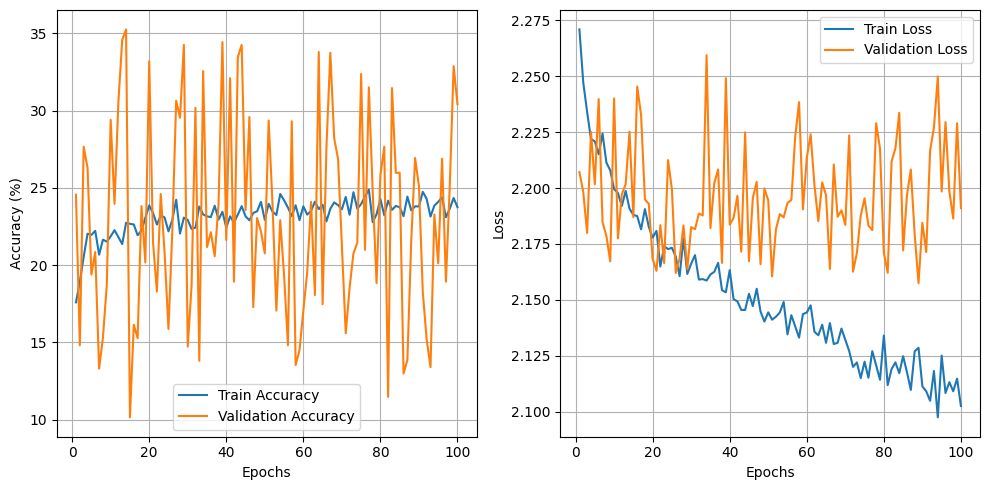

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/v5/representacion_3/longitud_28/{nombre_modelo}.png')
plt.show()

***Cargar el modelo :***

In [10]:
#modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)

modelo.load_state_dict(torch.load("./Modelos/v5/representacion_3/longitud_28/ConvNext_Tiny_fold_5.pth"))
modelo.to(device)
modelo.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

***Evaluar el modelo :***

In [11]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelo(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

***Matriz de confusión :***

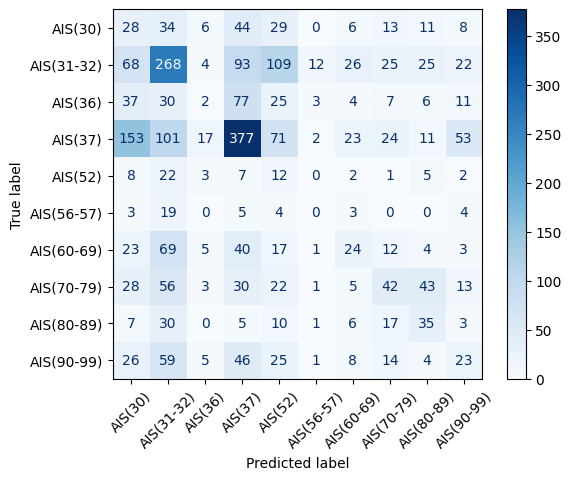

In [12]:
class_names = ['AIS(30)','AIS(31-32)','AIS(36)','AIS(37)','AIS(52)','AIS(56-57)','AIS(60-69)','AIS(70-79)','AIS(80-89)','AIS(90-99)']
#class_names = ['Cargo', 'Fishing', 'Military', 'Sailing', 'Tanker']
#class_names = ['Cargo','Container','Cruise','Fishing','Tanker']
#class_names = ['Cargo', 'Container','Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [13]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v5/representacion_3/longitud_28')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'ConvNext_Tiny_report.txt', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

     AIS(30)       0.07      0.16      0.10       179
  AIS(31-32)       0.39      0.41      0.40       652
     AIS(36)       0.04      0.01      0.02       202
     AIS(37)       0.52      0.45      0.48       832
     AIS(52)       0.04      0.19      0.06        62
  AIS(56-57)       0.00      0.00      0.00        38
  AIS(60-69)       0.22      0.12      0.16       198
  AIS(70-79)       0.27      0.17      0.21       243
  AIS(80-89)       0.24      0.31      0.27       114
  AIS(90-99)       0.16      0.11      0.13       211

    accuracy                           0.30      2731
   macro avg       0.20      0.19      0.18      2731
weighted avg       0.32      0.30      0.30      2731

